Select kernel `segment-anything`

Run this cell to import necessary packages and initialise SAM model and mask generator

In [1]:
import os

os.environ['PYTORCH_ENABLE_MPS_FALLBACK'] = '1'

In [60]:
# Import the necessary libraries
import numpy as np 
import torch
import matplotlib.pyplot as plt
from segment_anything import sam_model_registry, SamAutomaticMaskGenerator, SamPredictor
import cv2
from ultralytics import YOLO
from PIL import Image
import os
import shutil
from sklearn.model_selection import train_test_split
from IPython.display import display
from IPython.display import clear_output
import yaml
from ultralytics import YOLO
import glob
import pickle

from sam2yolo_functions import *

from jupyter_bbox_widget import BBoxWidget
import ipywidgets as widgets
import os
import json
import base64

sam_checkpoint = "../models/sam_vit_b_01ec64.pth" # Path to the checkpoint file
model_type = 'vit_b' # Model type

device = "cuda" if torch.cuda.is_available() else "mps" # Use GPU if available, otherwise use CPU

sam = sam_model_registry[model_type](checkpoint=sam_checkpoint) # Load the model
sam.to(device=device) # Move the model to the device

mask_generator = SamAutomaticMaskGenerator(sam) # Create a mask generator
mask_predictor = SamPredictor(sam) # Create a mask predictor

# Single Image

In [3]:
img_path = '../images/dog.jpg'

In [62]:
# helper function that loads an image before adding it to the widget
import base64


# this function returns the area of a mask (number of pixels)
def get_area(mask):
    area = 0
    for row in mask:
        for col in row:
            if col:
                area += 1
    return area


# this function returns the index of the mask with the largest area
def get_max_area(masks):
    max_area = 0
    idx = 0
    for i in range(len(masks)):
        if(get_area(masks[i]) > max_area):
            max_area = get_area(masks[i])
            idx = i
    return idx


import cv2
import numpy as np
import base64
from matplotlib import pyplot as plt

def overlay_mask_on_image(image, coord):
    # Ensure the mask is in 8-bit format
    image = cv2.drawContours(image, coord, -1, (0, 255, 0), 1)
    return image




def encode_image_mask(filepath, boxes):
    # read in the image file
    image = cv2.imread(filepath)
    h, w = image.shape[:2]
    poly_coords_list = []
    for box in boxes:
        # convert the bbox to format expected by mask_predictor
        box = np.array([
            box['x'],
            box['y'],
            box['x'] + box['width'],
            box['y'] + box['height']
        ])

        mask_predictor.set_image(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
        # predict the masks
        masks, scores, logits = mask_predictor.predict(
            box = box,
            multimask_output = True
        )

        # get the index of the mask with the largest area
        idx = get_max_area(masks)
        mask = masks[idx]

        # convert the pixel array format of the mask to a polygon coordinates
        polygon_coords = extract_segment(mask)
        poly_coords_list.append(polygon_coords)
        # overlay the mask on the image
        image = overlay_mask_on_image(image, polygon_coords)

    # convert the image with mask back to bytes
    is_success, im_buf_arr = cv2.imencode(".jpg", image)
    byte_im = im_buf_arr.tobytes()

    # encode to Base64 for rendering on the web
    encoded = base64.b64encode(byte_im).decode('utf-8')
    
    return "data:image/jpg;base64,"+encoded, poly_coords_list, h, w

In [16]:
widget = BBoxWidget(
    image = encode_image(img_path),
    classes=['plane', 'airtug']
)

widget


BBoxWidget(classes=['plane', 'airtug'], colors=['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564…

In [17]:
widget.bboxes

[{'x': 7, 'y': 217, 'width': 427, 'height': 309, 'label': 'plane'}]

In [18]:
box = np.array([
    widget.bboxes[0]['x'],
    widget.bboxes[0]['y'],
    widget.bboxes[0]['x'] + widget.bboxes[0]['width'],
    widget.bboxes[0]['y'] + widget.bboxes[0]['height']
])
image_bgr = cv2.imread(img_path) # read the image
image_rgb = cv2.cvtColor(image_bgr, cv2.COLOR_BGR2RGB) # convert the image to RGB
mask_predictor.set_image(image_rgb) # set the image for the mask predictor
masks, scores, logits = mask_predictor.predict(
    box = box,
    multimask_output = True
)

In [22]:
masks[0][0][0]

False

In [5]:
import numpy as np

# default_box is going to be used if you will not draw any box on image above
default_box = {'x': 68, 'y': 247, 'width': 555, 'height': 678, 'label': ''}

box_list = []

for box in widget.bboxes:
    box = np.array([ # convert the box to a numpy array
        box['x'],
        box['y'],
        box['x'] + box['width'],
        box['y'] + box['height']
    ])
    box_list.append(box)

import cv2
import numpy as np
import supervision as sv

image_bgr = cv2.imread(img_path) # read the image
image_rgb = cv2.cvtColor(image_bgr, cv2.COLOR_BGR2RGB) # convert the image to RGB

mask_predictor.set_image(image_rgb) # set the image for the mask predictor
predict_list = [] # initialise the predict list

for box in box_list:
    masks, scores, logits = mask_predictor.predict(
        box=box,
        multimask_output=True
    )
    predict_list.append([masks, scores, logits, box]) # append the masks, scores, logits and box to the predict list

NameError: name 'widget' is not defined

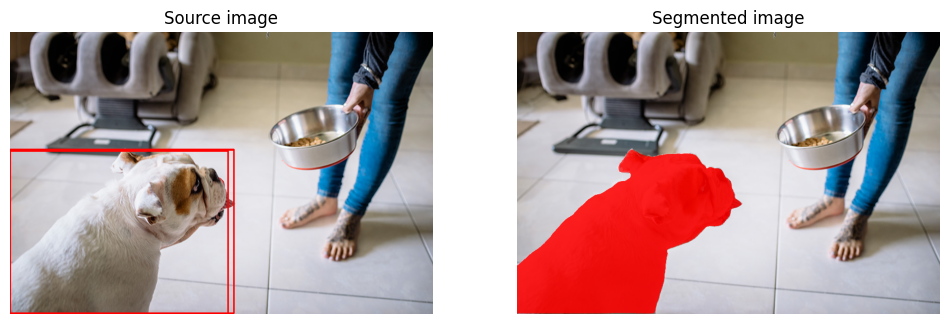

In [13]:
box_annotator = sv.BoxAnnotator(color=sv.Color.red()) # initialise the box annotator
mask_annotator = sv.MaskAnnotator(color=sv.Color.red()) # initialise the mask annotator

detections_list = [] # initialise the detections list

for predictions in predict_list:
    detections = sv.Detections(
        xyxy = sv.mask_to_xyxy(masks=predictions[0]), # convert the masks to xyxy format
        mask = predictions[0]
    )

    detections_list.append(detections) # append the detections to the detections list

for detections in detections_list:
    source_image = box_annotator.annotate(scene=image_bgr.copy(), detections=detections, skip_label=True) # annotate the image with the boxes
    segmented_image = mask_annotator.annotate(scene=image_bgr.copy(), detections=detections) # annotate the image with the masks

    sv.plot_images_grid(
        images=[source_image, segmented_image],
        grid_size=(1, 2),
        titles=['Source image', 'Segmented image']
    )


In [ ]:
import ipywidgets as widgets
from jupyter_bbox_widget import BBoxWidget

# List of images
images = ['image1.jpg', 'image2.jpg', 'image3.jpg']
current_image_index = 0

# BBoxWidget
bbox_widget = BBoxWidget(image=images[current_image_index], classes=['class1', 'class2', 'class3'])

# Button widgets
button_next = widgets.Button(description="Next")
button_prev = widgets.Button(description="Previous")

# Update function
def update_image(change):
    global current_image_index
    if change.description == "Next":
        current_image_index = (current_image_index + 1) % len(images)
    elif change.description == "Previous":
        current_image_index = (current_image_index - 1) % len(images)
    bbox_widget.image = images[current_image_index]

# Assign the update function to the buttons' click event
button_next.on_click(update_image)
button_prev.on_click(update_image)

# Display the widgets
display(button_prev, button_next, bbox_widget)

# Multi Image

In [63]:
path = '../images'
images = sorted(os.listdir(path))

annotations = {}
data = {}

In [64]:
def encode_image(filepath):
    with open(filepath, 'rb') as f:
        image_bytes = f.read()
    encoded = str(base64.b64encode(image_bytes), 'utf-8')
    return "data:image/jpg;base64,"+encoded

In [65]:
cur_img_idx = 0
classes = ['plane', 'airtug']

w_bbox = BBoxWidget(
    image = encode_image(os.path.join(path, images[cur_img_idx])),
    classes=classes
)

button_next = widgets.Button(description="Next")
button_prev = widgets.Button(description="Previous")

w_container = widgets.VBox([
    w_bbox,
    button_prev,
    button_next
])

In [66]:
def update_image(change):
    global cur_img_idx
    annotations[images[cur_img_idx]] = w_bbox.bboxes
    if change.description == "Next":
        cur_img_idx = (cur_img_idx + 1) % len(images)
    elif change.description == "Previous":
        cur_img_idx = (cur_img_idx - 1) % len(images)
        
    # check if annotations[cur_img_idx] exists
    if images[cur_img_idx] in annotations:
        w_bbox.bboxes = annotations[images[cur_img_idx]]
    else:
        w_bbox.bboxes = []
    w_bbox.image = encode_image(os.path.join(path, images[cur_img_idx]))

@w_bbox.on_submit
def submit():
    global cur_img_idx
    if len(w_bbox.bboxes) > 0:
        w_bbox.image, poly_coords_list, h, w = encode_image_mask(os.path.join(path, images[cur_img_idx]), w_bbox.bboxes)
        
        data[images[cur_img_idx]] = []
        
        i = 0
        for polygon_coords in poly_coords_list:
            label_id = [classes.index(w_bbox.bboxes[i]['label'])]
            flat_segment_coords = numpy_to_list(polygon_coords)

            for j in range(len(flat_segment_coords)): # normalise the coordinates of the segment
                if j%2 == 0:
                    flat_segment_coords[j] = flat_segment_coords[j]/w
                else:
                    flat_segment_coords[j] = flat_segment_coords[j]/h
            
            data[images[cur_img_idx]].append(label_id + flat_segment_coords)
            i += 1
        

In [68]:
button_next.on_click(update_image)
button_prev.on_click(update_image)

w_container

In [72]:
data

{'dog.jpg': [[0,
   0.50125,
   0.5299625468164794,
   0.41625,
   0.4344569288389513,
   0.26875,
   0.41947565543071164,
   0.23875,
   0.4812734082397004,
   0.2675,
   0.5168539325842697,
   0.165,
   0.5973782771535581,
   0.0,
   0.8295880149812734,
   0.0,
   0.9962546816479401,
   0.325,
   0.9943820224719101,
   0.35375,
   0.7734082397003745,
   0.4825,
   0.6835205992509363,
   0.52875,
   0.6104868913857678],
  [0,
   0.82,
   0.29213483146067415,
   0.7925,
   0.29213483146067415,
   0.77875,
   0.2602996254681648,
   0.69625,
   0.27715355805243447,
   0.635,
   0.31835205992509363,
   0.61375,
   0.3782771535580524,
   0.665,
   0.4812734082397004,
   0.7475,
   0.4812734082397004,
   0.7925,
   0.45318352059925093,
   0.8125,
   0.41947565543071164,
   0.8325,
   0.33146067415730335,
   0.81875,
   0.3464419475655431]],
 'groceries.jpg': [[0,
   0.77875,
   0.33707865168539325,
   0.70875,
   0.32771535580524347,
   0.6925,
   0.2602996254681648,
   0.6175,
   0.2734082

In [67]:
w_bbox.bboxes

[{'x': 325, 'y': 86, 'width': 355, 'height': 272, 'label': 'plane'}]